In [77]:
import pandas as pd
import datetime
import json
import numpy as np

In [3]:
blurb = pd.read_csv('blurb_validation_df.csv', index_col='Unnamed: 0')

In [4]:
oi = pd.read_csv('projects_fin.csv', index_col='Unnamed: 0')

In [5]:
projects = pd.merge(blurb, oi, left_on = 'name', right_on = 'name', how='inner')

<function matplotlib.pyplot.show(*args, **kw)>

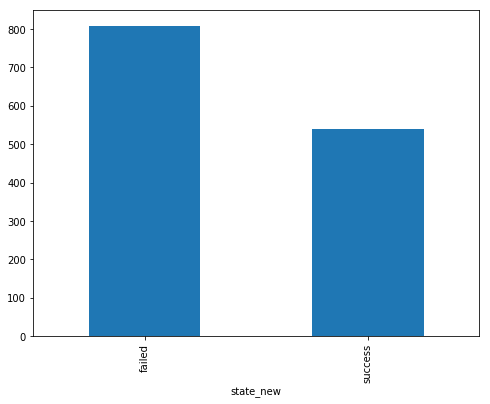

In [396]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
projects.groupby('state_new').blurb.count().plot.bar(ylim=0)
plt.show

This menas that if the model has no predicting power the accuracy should be 

# Basic preprocessing

In [6]:
projects['launched_year'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[0], axis = 1)
projects['launched_month'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[1], axis = 1)
projects['launched_day'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[2], axis = 1)
projects['launched_date'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[1] + x['launched'].split(" ")[0].split("-")[2], axis = 1)

In [7]:
projects['deadline_dt'] = projects.apply(lambda x: datetime.datetime.strptime(x['deadline'], "%Y-%m-%d").date(), axis = 1)
projects['launched_dt'] = projects.apply(lambda x: datetime.datetime.strptime(x['launched'].split(" ")[0], "%Y-%m-%d").date(), axis = 1)

In [8]:
projects['term'] = projects.apply(lambda x: int(str(x['deadline_dt'] - x['launched_dt']).split(" ")[0]), axis = 1)
projects['term_str'] = projects.apply(lambda x: str(x['term']), axis = 1)

In [9]:
# launch 날짜가 1970년으로 되어있는 row는 삭제
projects_new = projects[lambda x: x['term'] < 100]

In [10]:
projects_new = projects_new.reset_index().drop(['index'], axis = 1)

In [11]:
projects_new['term_str'] = projects_new.apply(lambda x: x['term_str'] if len(x['term_str']) != 1
                                             else '0' + x['term_str'], axis = 1)

In [12]:
# binnarize the dependent variable
projects_new['state_bin'] = projects_new['state_new'].apply(lambda x: 0 if x == 'failed' else 1)

In [13]:
# 10만원 이하로 펀딩 받는 경우는 지움
projects_fin = projects_new[projects_new['usd_goal_real'] > 100]

# Precise Preprocessing
- dtype conversion
- category labeling

In [246]:
train_data = projects_fin[['category', 'main_category', 'currency', 'country', 'usd_goal_real', 'state_bin', 'launched_year', 'launched_month', 'term', 'blurb']]

In [247]:
train = pd.DataFrame()

In [248]:
# lode vectorizatino labeling
with open('../non_nlp/cat_labels.json') as json_file:
    data = json.load(json_file)

In [249]:
# Assigning a categorical type to categorical varibles and vectorizing the categories for simplification

train['category'] = train_data['category'].map(data['category'])
train['main_category'] = train_data['main_category'].map(data['main_category'])
train['currency'] = train_data['currency'].map(data['currency'])
train['country'] = train_data['country'].map(data['country'])

In [250]:
train[['usd_goal_real', 'launched_year', 'launched_month', 'term', 'state', 'blurb']] = train_data[['usd_goal_real', 'launched_year', 'launched_month', 'term', 'state_bin', 'blurb']]

In [251]:
# remove NA values
train = train.dropna()

In [252]:
# turn categories into integer
train['category'] = train['category'].astype('int16')
train['main_category'] = train['main_category'].astype('int8')
train['currency'] = train['currency'].astype('int8')
train['country'] = train['country'].astype('int8')

In [253]:
train['launched_year'] = (train['launched_year']).astype('int')
train['launched_month'] = (train['launched_month']).astype('int')

# Test Data form

In [347]:
col = list(train.columns)
col.remove('blurb')

x = train[col]
y_test = train['state']

# non-NLP Model

In [348]:
import pickle

In [349]:
cb_clf = pickle.load(open('../non_nlp/Non_nlp_model', 'rb'))

In [350]:
y_pred = cb_clf.predict(x)

In [351]:
from sklearn.metrics import accuracy_score, f1_score

In [352]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.5510428100987926, 0.689445709946849)

# Creating the Vectorizer Fit for the Existing Model

In [353]:
peta = pd.read_csv("df_text_eng.csv")

In [354]:
del peta['Unnamed: 0'] 
from io import StringIO
peta['state_id'] = peta['state'].factorize()[0]
state_id_df = peta[['state', 'state_id']].drop_duplicates().sort_values('state_id')
state_to_id = dict(state_id_df.values)
id_to_state = dict(state_id_df[['state_id', 'state']].values)
data.head()

,blurb,state,state_id
0,"Using their own character, users go on educati...",failed,0
1,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful,1
2,"A small indie press, run as a collective for a...",failed,0
3,Zylor is a new baby cosplayer! Back this kicks...,failed,0
4,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed,0


In [355]:
import re
def clean(text):
    text = str(text)
    text = re.findall(r'\w+', text)
    return ' '.join(text)
peta['blurb'] = peta['blurb'].apply(lambda x: clean(x))

In [356]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
x_train, x_zeta, y_zeta, y_peta = train_test_split(peta['blurb'], peta['state'], train_size=0.7, random_state=42)
vectorizer = TfidfVectorizer().fit(x_train)

# NLP Model

In [357]:
import re
def clean(text):
    text = str(text)
    text = re.findall(r'\w+', text)
    return ' '.join(text)
train['blurb'] = train['blurb'].apply(lambda x: clean(x))

In [358]:
x_blurb = train['blurb'].copy()

x_blurb_vec = vectorizer.transform(x_blurb)

In [359]:
lg_clf = pickle.load(open('../nlp/nlp_model.sav', 'rb'))

In [360]:
result = pd.DataFrame(lg_clf.predict(x_blurb_vec))

In [361]:
y_pred = result[0].apply(lambda x: 0 if x == 'failed' else 1)

In [362]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.63919259882254, 0.6742596810933941)

# Voting Parameter

In [380]:
y_final_pred = (cb_clf.predict_proba(x) + lg_clf.predict_proba(x_blurb_vec))[:,1] /2

In [386]:
f1_score(y_test, sex), accuracy_score(y_test, sex)

(0.6420950533462657, 0.7198177676537585)

### Voting Parameter Tuning

In [399]:
type(x1)

numpy.ndarray

In [405]:
x1 = np.arange(0, 1.01, 0.01)
y1 = np.arange(0, 1.01, 0.01)
z1 = np.arange(0, 1.01, 0.01)
r1 = np.full((101, ), 0.6)

from sklearn.metrics import accuracy_score, f1_score

for i in np.arange(0, 1.01, 0.01):
    y_proba = ((y_final_pred) > i).astype(int)
    y1[int(i*100)] = accuracy_score(y_test, y_proba)
    z1[int(i*100)] = f1_score(y_test, y_proba)

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to

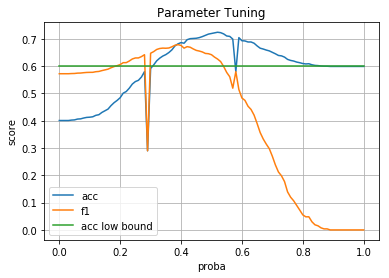

In [411]:
ax = plt.subplot(111)

ax.plot(x1, y1, label='acc')
ax.plot(x1, z1, label='f1')
ax.plot(x1, r1, label='acc low bound')

ax.set(xlabel='proba', ylabel='score', title='Parameter Tuning')
ax.legend(loc='lower left')
ax.grid()

In [393]:
print('max accuracy:', max(y1))
print('max f1 score:', max(z1))

max accuracy: 0.724373576309795
max f1 score: 0.6789272030651341
